
Results for query: Who is Dante Dinawanao?

Compressed (LLM):


,Title,Chunk Index,Score
2,Travel Permit for Assoc. Prof. Dante D. Dinawanao,0,0.518978
1,Special Order No. 1386 - IIT Series of 2012,2,0.471383
0,Special Order No. 1386 - IIT Series of 2012,1,0.453735


Threshold (≥0.4):


,Title,Chunk Index,Score
2,Award for Dr. Nelia G. Balgoa's International Conference Presentation,1,0.556351
4,Designations and Renewals at Mindanao State University,3,0.555567
6,Special Order No. 1386 - IIT Series of 2012,0,0.547617
3,Designations and Renewals at Mindanao State University,2,0.545852
5,Mindanao State University Academic Promotion Policy,32,0.543788
0,Authority for DTI-Funded Research Project on CMCI,1,0.543508
1,Authority for DTI-Funded Research Project on CMCI,3,0.523607
9,Travel Permit for Assoc. Prof. Dante D. Dinawanao,0,0.518978
8,Special Order No. 1386 - IIT Series of 2012,2,0.471383
7,Special Order No. 1386 - IIT Series of 2012,1,0.453735


Original (k=10):


,Title,Chunk Index,Score
2,Award for Dr. Nelia G. Balgoa's International Conference Presentation,1,0.556351
4,Designations and Renewals at Mindanao State University,3,0.555567
6,Special Order No. 1386 - IIT Series of 2012,0,0.547617
3,Designations and Renewals at Mindanao State University,2,0.545852
5,Mindanao State University Academic Promotion Policy,32,0.543788
0,Authority for DTI-Funded Research Project on CMCI,1,0.543508
1,Authority for DTI-Funded Research Project on CMCI,3,0.523607
9,Travel Permit for Assoc. Prof. Dante D. Dinawanao,0,0.518978
8,Special Order No. 1386 - IIT Series of 2012,2,0.471383
7,Special Order No. 1386 - IIT Series of 2012,1,0.453735


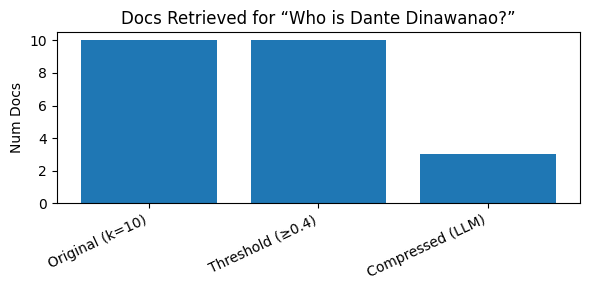


Results for query: When was Dante Dinawanao went to United States

Compressed (LLM):


,Title,Chunk Index,Score
0,Travel Permit for Assoc. Prof. Dante D. Dinawanao,0,0.414202


Threshold (≥0.4):


,Title,Chunk Index,Score
5,Granting Cash Incentives for Sa Umaabot Poetry Contest Winners,0,0.504012
0,Authority for DTI-Funded Research Project on CMCI,2,0.500121
1,Authority for DTI-Funded Research Project on CMCI,3,0.493961
2,Authorization of Travel for Assoc. Prof. Angiline L. Teatro,1,0.492671
8,Suspension of Ms. Marissa C. Bola,18,0.488843
3,Designations and Renewals at Mindanao State University,3,0.481529
4,Designations and Renewals at Mindanao State University,8,0.469633
6,MSU BOARD OF REGENTS Resolution No. 1610,3,0.441437
9,Travel Permit for Assoc. Prof. Dante D. Dinawanao,0,0.414202
7,Special Order No. 1386 - IIT Series of 2012,1,0.411895


Original (k=10):


,Title,Chunk Index,Score
5,Granting Cash Incentives for Sa Umaabot Poetry Contest Winners,0,0.504012
0,Authority for DTI-Funded Research Project on CMCI,2,0.500121
1,Authority for DTI-Funded Research Project on CMCI,3,0.493961
2,Authorization of Travel for Assoc. Prof. Angiline L. Teatro,1,0.492671
8,Suspension of Ms. Marissa C. Bola,18,0.488843
3,Designations and Renewals at Mindanao State University,3,0.481529
4,Designations and Renewals at Mindanao State University,8,0.469633
6,MSU BOARD OF REGENTS Resolution No. 1610,3,0.441437
9,Travel Permit for Assoc. Prof. Dante D. Dinawanao,0,0.414202
7,Special Order No. 1386 - IIT Series of 2012,1,0.411895


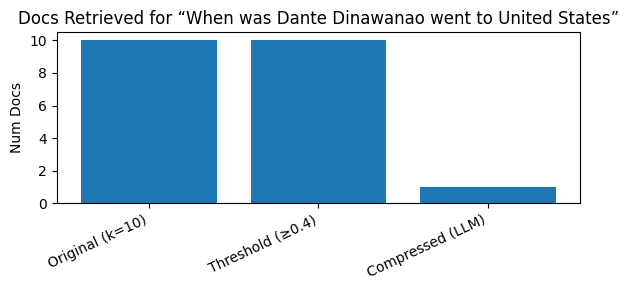

In [136]:
import os
import sys
import asyncio
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from asgiref.sync import sync_to_async
from IPython.display import display

# If running in a Jupyter environment, allow nested event loops
try:
    import nest_asyncio
    nest_asyncio.apply()
except ImportError:
    pass

# Django setup
notebook_dir = Path().absolute()
sys.path.insert(0, str(notebook_dir))
if 'DJANGO_SETTINGS_MODULE' in os.environ:
    del os.environ['DJANGO_SETTINGS_MODULE']
os.environ['DJANGO_SETTINGS_MODULE'] = 'inteldocs.settings'
import django
django.setup()

from app.services.vectorstore import vector_store
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMListwiseRerank
from langchain_ollama import ChatOllama
from app.models import Document

# Ensure full titles are shown and no wrapping
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.width', None)

async def get_title(doc_id):
    try:
        d = await sync_to_async(Document.objects.get, thread_sensitive=False)(id=doc_id)
        return d.title
    except Document.DoesNotExist:
        return None

async def process_query(q, top_k, score_threshold, llm_compressor, base_store):
    # 1) Original—pull top_k with scores
    orig_pairs = base_store.similarity_search_with_score(q, k=top_k)
    # 2) Threshold—filter those by score
    thresh_pairs = [(doc, score) for doc, score in orig_pairs if score >= score_threshold]
    # 3) Compressed—just docs, no scores
    compressed_docs = llm_compressor.invoke(q)

    # Map doc_id and chunk_index to score for retrieving compressed scores
    score_map = {
        (doc.metadata.get("doc_id"), doc.metadata.get("index")): score
        for doc, score in orig_pairs
    }

    # Counts for bar chart
    counts = {
        f"Original (k={top_k})": len(orig_pairs),
        f"Threshold (≥{score_threshold})": len(thresh_pairs),
        "Compressed (LLM)": len(compressed_docs),
    }

    # Build flat records list
    records = []
    for name, entries in [
        (f"Original (k={top_k})", orig_pairs),
        (f"Threshold (≥{score_threshold})", thresh_pairs),
    ]:
        for doc, score in entries:
            title = await get_title(doc.metadata.get("doc_id"))
            records.append({
                "Retriever": name,
                "Title": title,
                "Chunk Index": doc.metadata.get("index"),
                "Score": score,
            })
    for doc in compressed_docs:
        doc_id = doc.metadata.get("doc_id")
        chunk_index = doc.metadata.get("index")
        title = await get_title(doc_id)
        score = score_map.get((doc_id, chunk_index))
        records.append({
            "Retriever": "Compressed (LLM)",
            "Title": title,
            "Chunk Index": chunk_index,
            "Score": score if score is not None else None,
        })

    # Build DataFrame and MultiIndex
    df = pd.DataFrame(records)
    df = df.sort_values(['Retriever','Score'], ascending=[True, False])
    df_multi = df.set_index(['Retriever','Title','Chunk Index']).sort_index()

    # Print each section in custom order, sorting by score
    print(f"\nResults for query: {q}\n")
    order = [
        "Compressed (LLM)",
        f"Threshold (≥{score_threshold})",
        f"Original (k={top_k})"
    ]
    for name in order:
        print(f"{name}:")
        try:
            section = df_multi.loc[name]
            section_df = section.reset_index()
            # Sort by Score descending, None last
            section_df['Score'] = pd.to_numeric(section_df['Score'], errors='coerce')
            section_df = section_df.sort_values('Score', ascending=False, na_position='last')
            # Render at 100% width in Jupyter
            styled = section_df.style.set_table_attributes('style="width:100%;"')
            display(styled)
        except KeyError:
            print("  (no results)\n")

    # Bar chart
    plt.figure(figsize=(6, 3))
    plt.bar(counts.keys(), counts.values())
    plt.ylabel("Num Docs")
    plt.title(f"Docs Retrieved for “{q}”")
    plt.xticks(rotation=25, ha="right")
    plt.tight_layout()
    plt.show()

async def main():
    TOP_K = 10
    SCORE_THRESHOLD = 0.4

    llm = ChatOllama(model="llama3.1:8b", base_url="http://ollama:11434", temperature=0)
    compressor = LLMListwiseRerank.from_llm(llm)
    score_retriever = vector_store.as_retriever(
        search_type="similarity_score_threshold",
        search_kwargs={"score_threshold": SCORE_THRESHOLD}
    )
    compression_retriever = ContextualCompressionRetriever(
        base_compressor=compressor,
        base_retriever=score_retriever
    )

    queries = [
        "Who is Dante Dinawanao?",
        "When was Dante Dinawanao went to United States"
    ]
    for q in queries:
        await process_query(q, TOP_K, SCORE_THRESHOLD, compression_retriever, vector_store)

if __name__ == "__main__":
    try:
        asyncio.run(main())
    except RuntimeError:
        loop = asyncio.get_event_loop()
        loop.run_until_complete(main())
